<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/notebooks/Station_Buildings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --quiet duckdb
!pip install --quiet jupysql
!pip install --quiet duckdb-engine
!pip install --quiet pandas
!pip install --quiet matplotlib
!pip install -q osmnx
!pip install -q pydeck

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 42.1 MB/s eta 0:00:00


In [14]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
from tqdm import tqdm
import pydeck as pdk
import shapely
import duckdb
import time
import warnings
warnings.filterwarnings('ignore')

# Import jupysql Jupyter extension to create SQL cells
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


## Setup duckdb

In [8]:
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:
# %sql duckdb:///path/to/file.db

In [9]:
%%sql
INSTALL httpfs;
INSTALL spatial;

,Success


## Download OSM data

In [10]:
## Note: the coordinates are in West, South, East, North format

bboxs = {
    'Mumbai': (72.7712628039,18.8895552464,73.0912396106,19.322318006),
    'Hyderabad': (78.2288393192,17.1952635128,78.692325037,17.6244114807),
    'Bangalore': (77.4480254838,12.815481916,77.7549560258,13.1026335949),
    'Chennai': (80.0337033915,12.8678089117,80.335827415,13.2370438819),
    'Kolkata': (88.2431406976,22.4883995072,88.4944529534,22.7071046611),
    'Ahmedabad': (72.4617185823,22.9179551449,72.699297928,23.1470216925),
    'Delhi_NCR': (76.881197,28.31444,77.604922,28.893765)
}

columns = ['element_type', 'osmid', 'geometry', 'railway', 'internet_access',
       'name', 'name:hi', 'network', 'operator', 'public_transport',
       'ref', 'train','city']

## Select city
city = "Mumbai"
W,S,E,N = bboxs[city]

Download all the station nodes:

In [63]:
%%time

public_transport = ox.features.features_from_bbox(
    bbox=(N,S,E,W),
    tags={
        'railway': ['stop', 'station'],
        'subway':True
        }
).reset_index()

## Extract the station data:
pb = public_transport[public_transport['element_type']=='node'].copy()
columns = ['element_type', 'osmid', 'geometry', 'railway', 'internet_access',
       'name', 'network', 'operator', 'public_transport',
       'ref', 'train','subway','station']

pb_gdf = pb[columns]
pb_gdf = pb_gdf.fillna('None')
# metro_stations = pb_gdf[pb_gdf['network'].str.lower().str.contains('metro')]
print("Total nodes with station tag:",pb_gdf.shape[0])
pb_gdf.sample(min(5,len(pb_gdf)))

<timed exec>:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.


Total nodes with station tag: 573
CPU times: user 240 ms, sys: 3.47 ms, total: 244 ms
Wall time: 251 ms


,element_type,osmid,geometry,railway,internet_access,name,network,operator,public_transport,ref,train,subway,station
374,node,7802015658,POINT (72.98405 19.29821),stop,None,Kharbhav,None,None,stop_position,None,yes,None,None
67,node,1234823928,POINT (72.83527 18.94061),stop,None,CSMT,None,None,stop_position,CSTM:3,yes,None,None
456,node,7818209607,POINT (73.00706 19.11642),stop,None,Ghansoli,None,None,stop_position,None,yes,None,None
459,node,7818210886,POINT (72.99933 19.15856),stop,None,Airoli,None,None,stop_position,None,yes,None,None
449,node,7818124497,POINT (73.03900 19.01914),stop,None,CBD Belapur,None,None,stop_position,None,yes,None,None


In [48]:
# metro_stations = pb_gdf[pb_gdf['subway']=='yes']
# railway_stations = pb_gdf.loc[~(pb_gdf['subway']=='yes')]

In [65]:
pb_gdf['station'].value_counts()

station
None          510
subway         44
monorail       17
light_rail      1
terminal        1
Name: count, dtype: int64

In [64]:
pb_gdf['subway'].value_counts()

subway
None    390
yes     183
Name: count, dtype: int64

In [66]:
pb_gdf.to_gpkg(f'{city}_stations_stops.gpkg', driver='GPKG')

(573, 13)

Export the results

In [51]:
# metro_stations.to_file(f'{city}_stations_stops.gpkg', driver='GPKG')
# railway_stations.to_file(f'{city}_railway_stations_stops.gpkg', driver='GPKG')

## Corrected Station Locations

Station nodes in OSM maynot be labelled with correct tags, so this may required evaluation before processing.



In [67]:
stations = pb_gdf.copy()
stations = stations.to_crs('EPSG:32643')
stations['geometry'] = stations['geometry'].buffer(10)
stations = stations.to_crs("EPSG:4326")
stations.head()

,element_type,osmid,geometry,railway,internet_access,name,network,operator,public_transport,ref,train,subway,station
0,node,30518297,"POLYGON ((72.85319 19.31027, 72.85319 19.31026...",station,no,Bhayandar,IR,WR,station,BYR,yes,None,None
1,node,30518361,"POLYGON ((72.98456 19.29832, 72.98456 19.29831...",station,no,Kharbhav,IR,CR,station,KHBV,yes,None,None
2,node,213017960,"POLYGON ((73.04641 19.26887, 73.04641 19.26887...",station,no,Bhivandi Road,IR,CR,station,BIRD,yes,None,None
3,node,213030669,"POLYGON ((72.85972 19.24945, 72.85972 19.24944...",station,no,Dahisar,IR,WR,station,DIC,yes,None,None
4,node,213030688,"POLYGON ((72.84885 19.18681, 72.84885 19.18680...",stop,None,Malad,None,None,stop_position,None,yes,None,None


In [68]:
# print(metro_stations.shape, stations.shape)
# dfx = pd.concat([metro_stations, stations])
stations.drop(['osmid'], axis=1).to_parquet('stations-corrected.parquet')

In [69]:
stations.geometry.geom_type.unique()

array(['Polygon'], dtype=object)

## Download Station Buildings

Downloading the buildings from overturemaps using duckdb

The overture map's data keeps on updating month on month. Refer to the release notes to download the latest data: [lastest releases](https://docs.overturemaps.org/release/latest/)

[Download Overture Maps Data](https://overturemaps.org/download/)



In [70]:
%%time

buildings_data_url = r"'s3://overturemaps-us-west-2/release/2024-07-22.0/theme=buildings/type=*/*'"
stations_data_url = "'stations-corrected.parquet'"

df = duckdb.sql(
    f'''
    LOAD spatial;
    LOAD httpfs;
    COPY(
        SELECT
            id,
            names.primary as name,
            buildings.height as height,
            stations.name as station_name,
            stations.network as network,
            stations.operator as operator,
            stations.railway as railway,
            stations.subway as subway,
            stations.station as station,
            ST_GeomFromWKB(buildings.geometry) as geom
        FROM read_parquet({buildings_data_url}, filename=true, hive_partitioning=1) AS buildings
        JOIN read_parquet({stations_data_url}) as stations
        ON ST_Intersects(ST_GeomFromWKB(buildings.geometry), ST_GeomFromWKB(stations.geometry))
        WHERE buildings.bbox.xmin > {W}
        AND buildings.bbox.xmax < {E}
        AND buildings.bbox.ymin > {S}
        AND buildings.bbox.ymax < {N}
    ) TO 'station_buildings.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON');
    '''
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 16.2 s, sys: 1.76 s, total: 18 s
Wall time: 6min 14s


In [71]:
sbf = gpd.read_file('station_buildings.geojson').drop_duplicates('geometry')  ## Unique Building footprints
print('Stations with enclosing buildings:', sbf.shape[0])
sbf.sample(5)

Stations with enclosing buildings: 449


,id,name,height,station_name,network,operator,railway,subway,station,geometry
122,08b608b425802fff02007f69d2714ff3,None,None,None,None,None,stop,None,None,"POLYGON ((72.99795 19.19632, 72.99790 19.19638..."
766,08b608b0140b4fff02008ed523c25286,None,None,Charni Road,WR,IR,stop,None,None,"POLYGON ((72.81691 18.95286, 72.81686 18.95289..."
201,08b608b463b89fff0200ca736002437c,None,None,Lower Malad,None,None,stop,yes,None,"POLYGON ((72.83598 19.17218, 72.83623 19.17210..."
826,08b608b03250dfff02002702c6056177,None,None,CSMT,None,None,stop,None,None,"POLYGON ((72.83564 18.94278, 72.83566 18.94258..."
397,08b608b0b319cfff02003da09bfe53ac,None,None,Santa Cruz (WR),None,None,stop,None,None,"POLYGON ((72.84191 19.08155, 72.84188 19.08155..."


This will give all the building footprints surrounding the station nodes.
Note that buildings are based on overture maps which is not so well updated. There might me some stations without a enclosing building footprint

Let's find out those stations:

In [77]:
if sbf['id'].isna().sum()>0:
    no_bf = stations[stations[['geometry']].reset_index(drop=True).sjoin(sbf.reset_index(drop=True), how='left', predicate='intersects').id.isna()].copy()
    print('Stations without enclosing buildings:', no_bf.shape[0])

    no_bf.to_file('stations_wo_BF.gpkg', driver='GPKG')
    no_bf.to_parquet("stations_wo_BF.parquet")

else:
    no_bf = None

## Download building footprints from VIDA


[Google-Microsoft Open Buildings - combined by VIDA](https://beta.source.coop/repositories/vida/google-microsoft-open-buildings/description/):

This dataset merges Google's V3 Open Buildings and Microsoft's latest Building Footprints. With 2,534,595,270 footprints, it is to our knowledge the most complete openly available dataset as of Sep. 2023. It covers 92% of Level 0 administrative boundaries, and is divided into 182 partitions. Each footprint is labelled with its respective source, either Google or Microsoft. It can be accessed in cloud-native geospatial formats such as GeoParquet, FlatGeobuf and PMTiles

Load the building polygons

In [79]:
%%time
stations_data_url = "'stations_stops.parquet'"
prefix = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-open-buildings/geoparquet"
partitions = "by_country"
country_iso = "IND"

duckdb.sql(f'''
describe FROM '{prefix}/{partitions}/country_iso={country_iso}/{country_iso}.parquet' AS buildings
''')

CPU times: user 96.6 ms, sys: 22.4 ms, total: 119 ms
Wall time: 2.32 s


┌────────────────┬─────────────┬─────────┬─────────┬─────────┬─────────┐
│  column_name   │ column_type │  null   │   key   │ default │  extra  │
│    varchar     │   varchar   │ varchar │ varchar │ varchar │ varchar │
├────────────────┼─────────────┼─────────┼─────────┼─────────┼─────────┤
│ geometry       │ BLOB        │ YES     │ NULL    │ NULL    │ NULL    │
│ boundary_id    │ BIGINT      │ YES     │ NULL    │ NULL    │ NULL    │
│ bf_source      │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
│ confidence     │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ area_in_meters │ DOUBLE      │ YES     │ NULL    │ NULL    │ NULL    │
│ country_iso    │ VARCHAR     │ YES     │ NULL    │ NULL    │ NULL    │
└────────────────┴─────────────┴─────────┴─────────┴─────────┴─────────┘

In [80]:
if no_bf is not None:

    start_time = time.time()

    stations_data_url = "'stations_stops.parquet'"
    prefix = "s3://us-west-2.opendata.source.coop/vida/google-microsoft-open-buildings/geoparquet"
    partitions = "by_country"
    country_iso = "IND"

    query = f'''
    COPY(
        SELECT
        ST_Xmin(ST_GeomFromWKB(buildings.geometry)) as xmin,
        ST_Xmax(ST_GeomFromWKB(buildings.geometry)) as xmax,
        ST_Ymin(ST_GeomFromWKB(buildings.geometry)) as ymin,
        ST_Ymax(ST_GeomFromWKB(buildings.geometry)) as ymax,
        confidence,
        bf_source,
        ST_GeomFromWKB(buildings.geometry)
        FROM '{prefix}/{partitions}/country_iso={country_iso}/{country_iso}.parquet' as buildings
        JOIN read_parquet({stations_data_url}) as stations
        ON ST_Within(ST_GeomFromWKB(stations.geometry), ST_GeomFromWKB(buildings.geometry))
        WHERE xmin > {W}
        AND xmax < {E}
        AND ymin > {S}
        AND ymax < {N}
    ) TO 'ML_station_buildings.geojson' WITH (FORMAT GDAL, DRIVER 'GeoJSON');
    '''

    duckdb.sql(query)

    end_time = (time.time()-start_time)/60

    print(f"Time taken to process the request: {end_time:2f} mins")

In [81]:
# gdf = gpd.read_file('ML_station_buildings.geojson')
# print(gdf.shape)

In [82]:
# gdf.sample(5)

In [83]:
# gpd.read_parquet('stations_stops.parquet')

## Download the railway lines

In [87]:
%%time

public_transport_routes = ox.features.features_from_bbox(
    bbox=(N,S,E,W),
    tags={
        'railway': ['subway', 'rail','monorail'],
        }
).reset_index()

## Extract the station data:
routes = public_transport_routes[public_transport_routes['element_type']=='way'].copy()
route_columns = ['element_type', 'osmid', 'geometry', 'railway',
       'name', 'network', 'operator',
       'ref','source','start_date']

route_gdf = routes[route_columns]
route_gdf = route_gdf.fillna('None')
print("Total ways with rail tag:",route_gdf.shape[0])
route_gdf.sample(min(5,len(route_gdf)))

<timed exec>:1: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.


Total ways with rail tag: 2173
CPU times: user 488 ms, sys: 7.86 ms, total: 496 ms
Wall time: 495 ms


,element_type,osmid,geometry,railway,name,network,operator,ref,source,start_date
53,way,48912721,"LINESTRING (72.82060 18.97401, 72.82081 18.974...",rail,None,None,None,None,None,None
664,way,561526755,"LINESTRING (73.01322 19.05513, 73.01288 19.055...",rail,Sanpada Carshed,None,None,None,None,None
877,way,658993949,"LINESTRING (72.84011 18.96339, 72.84025 18.963...",rail,None,None,None,None,None,None
1194,way,807900829,"LINESTRING (72.84533 19.02044, 72.84506 19.01998)",rail,None,None,None,None,None,None
736,way,602887032,"LINESTRING (73.01731 19.02886, 73.01703 19.02833)",rail,None,None,None,None,None,None


<Axes: >

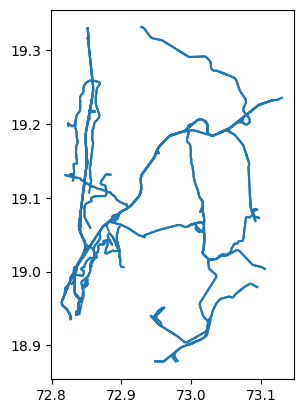

In [88]:
route_gdf.plot()

In [89]:
route_gdf.to_file(f"{city}_public_transport_route.gpkg", driver='GPKG')